In [1]:
import numpy as np
import seaborn as sns
import torch
import os
import skimage
import matplotlib.pyplot as plt

# Load from saved explanations

In [2]:
SAVED_EXPLANATIONS_DIR = os.path.join('explanations', 'random')
SAVED_EXPLANATIONS_DIR

'explanations\\random'

In [3]:
blackboxes = ['InceptionV3', 'ResNet']
explanations = dict()
methods = set()

for blackbox in blackboxes:
    explanations[blackbox] = dict()
    
    directory = os.path.join(SAVED_EXPLANATIONS_DIR, blackbox)
    for file in os.listdir(directory):
        method = os.path.basename(file).split('.')[0]
        methods.add(method)

        path = os.path.join(directory, file)
        exp = torch.load(path)

        explanations[blackbox][method] = exp

methods = list(methods)
methods.sort()
print(f'Blackboxes: {blackboxes}')
print(f'Methods: {methods}')

Blackboxes: ['InceptionV3', 'ResNet']
Methods: ['FeatureAblation', 'GradientShap', 'GuidedBackprop', 'GuidedGradCam', 'IntegratedGradients', 'LRP', 'Occlusion', 'Saliency']


# Metrics

## Metrics from the paper _The Disagreement Problem in Explainable Machine Learning_

In [4]:
def feature_agreement(x, y, k=1638):
    _, i1 = torch.topk(torch.Tensor(x).flatten().abs(), k)
    _, i2 = torch.topk(torch.Tensor(y).flatten().abs(), k)
    i1 = set(torch.unique(i1).tolist())
    i2 = set(torch.unique(i2).tolist())
    intersect = len(i1.intersection(i2))
    return 1.0 * intersect / k

In [5]:
def sign_agreement(x, y, k=1638):
    x_flatten = x.flatten()
    y_flatten = y.flatten()
    x_topk = np.argpartition(np.absolute(x_flatten), -k)[-k:]
    y_topk = np.argpartition(np.absolute(y_flatten), -k)[-k:]
    
    intersect = np.intersect1d(x_topk, y_topk)
    same_sign = np.asarray(list(map(lambda ind: np.sign(x_flatten[ind]) == np.sign(y_flatten[ind]), intersect)))
    return same_sign.sum() * 1.0 / k

In [6]:
def rank_correlation(x, y):
    return scipy.stats.spearmanr(x.flatten().abs(), y.flatten().abs()).correlation

## Structural Similarity Index

In [7]:
def ssim(x, y):
    return skimage.metrics.structural_similarity(normalize(x), normalize(y), data_range=1.0)

# Computing disagreement and visualizing

In [8]:
def normalize(x):
    t = (x - np.min(x)) / (np.max(x) - np.min(x))
    return t

In [9]:
def normalize_sum_to_one(x):
    norm = normalize(x)
    return norm / norm.sum()

In [10]:
def compute_mean_disagreement(exp1, exp2, metric, **options):
    metrics = []
    for e1, e2 in zip(exp1, exp2):
        metrics.append(metric(e1, e2, **options))
    return np.array(metrics).mean()

In [11]:
# Compute disagreement heatmap for one blackbox
def compute_heatmap(methods, explanations, metric, **options):
    size = len(methods)
    result = np.empty((size, size))

    for j in range(size):
        for i in range(size):
            exp1 = explanations[methods[i]]
            exp2 = explanations[methods[j]]
            
            if isinstance(exp1, torch.Tensor):
                exp1 = exp1.cpu().numpy()
            
            if isinstance(exp2, torch.Tensor):
                exp2 = exp2.cpu().numpy()
            
            if i >= j:
                result[i, j] = compute_mean_disagreement(exp1, exp2, metric, **options)
            else:
                result[i, j] = result[j, i]
    return result

In [12]:
def compute_heatmaps(explanations, methods, metric, **options):
    result = dict()
    for k, v in explanations.items():
        result[k] = compute_heatmap(methods, v, metric, **options)
    return result

In [13]:
def visualize(hm, title='', ax=None, show_yticklables=True):
    return sns.heatmap(
        hm,
        annot=True,
        xticklabels=methods,
        yticklabels=methods if show_yticklables else [],
        cmap='Blues',
        ax=ax
    ).set(title=title)

In [14]:
def visualize_many(heatmaps, metric_name=''):
    num_black_boxes = len(heatmaps.keys())
    fig, axes = plt.subplots(nrows=1, ncols=num_black_boxes, figsize=(18,6))
    
    if num_black_boxes == 1:
        axes = [axes]
    
    for i, blackbox in enumerate(heatmaps.keys()):
        show_yticklabels = i == 0
        hm = visualize(
            hm=heatmaps[blackbox],
            title=blackbox,
            ax=axes[i], 
            show_yticklables=show_yticklabels
        )
    
    fig.suptitle(metric_name)
    return fig, axes

## Feature Agreement

In [15]:
%%time
heatmap_fa = compute_heatmaps(explanations, methods, metric=feature_agreement)

CPU times: total: 1.11 s
Wall time: 1.19 s


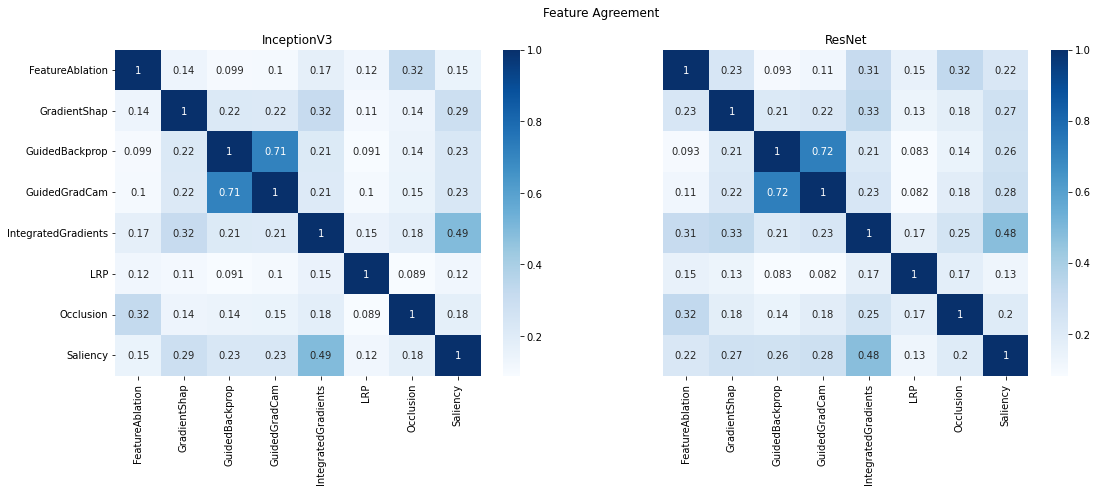

In [16]:
visualize_many(heatmap_fa, metric_name='Feature Agreement')
plt.show()

## Sign Agreement

In [17]:
%%time
heatmap_sa = compute_heatmaps(explanations, methods, metric=sign_agreement)

CPU times: total: 2.17 s
Wall time: 2.19 s


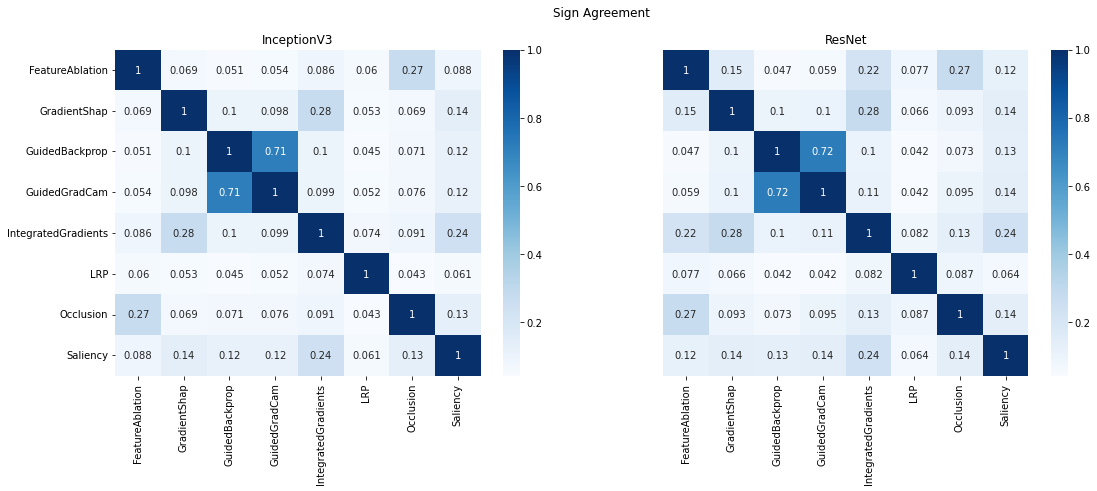

In [18]:
visualize_many(heatmap_sa, metric_name='Sign Agreement')
plt.show()

## Rank correlation

In [19]:
# Need masked explanations

## SSIM

In [20]:
%%time
heatmap_ssim = compute_heatmaps(explanations, methods, metric=ssim)

CPU times: total: 875 ms
Wall time: 878 ms


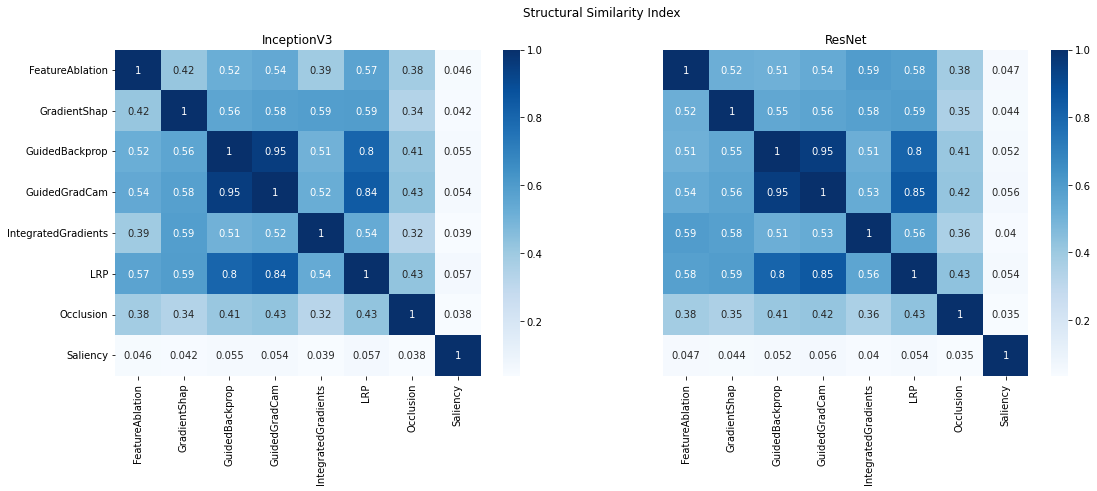

In [21]:
visualize_many(heatmap_ssim, metric_name='Structural Similarity Index')
plt.show()